In [1]:
import numpy as np 
import pandas as pd 
import re, itertools, json, os, random, contractions, nltk, warnings
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob as TB
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from wordcloud import WordCloud
from collections import Counter
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from datetime import datetime
from bs4 import BeautifulSoup
from textblob import Word

/home/ankushraut/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def sentiment_analyzer(x):
    if x<0.3:
        return -1
    elif x>0.55:
        return 1
    else:
        return 0

In [3]:
training = pd.read_csv('training_data (1).csv')
training.dropna(inplace = True)

In [4]:
bag_of_words_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bag_of_words = bag_of_words_vectorizer.fit_transform(training.text)

In [5]:
booster = xgb.Booster({'nthread':4}) #init model
booster.load_model("prediction_model.model") # load data

In [7]:
nykaa_website = pd.read_csv('nykaa_website.csv')

In [8]:
lem = WordNetLemmatizer()

def strip_html(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        y = soup.get_text()
    except ValueError:
        pass
    return y

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    try:
        text = strip_html(text)
        try:
            text = remove_between_square_brackets(text)
        except ValueError:
            pass
    except ValueError:
        pass
    return text

def replace_contractions(text):
    return contractions.fix(text)

In [9]:
nykaa_website.dropna(inplace = True)
nykaa_website = nykaa_website.reset_index(drop = True)

In [10]:
nykaa_website.review = nykaa_website.review.map(lambda x: denoise_text(x))        
nykaa_website.review = nykaa_website.review.map(lambda x: replace_contractions(x))
nykaa_website.review = nykaa_website.review.str.replace('[^\w\s]',' ')
nykaa_website.review = nykaa_website.review.apply(lambda x: " ".join(x.lower() for x in x.split()))

In [13]:
nykaa_website.time = pd.to_datetime(nykaa_website.time)

In [14]:
nykaa_website = nykaa_website[(nykaa_website.time>= datetime(2018, 3, 1)) & 
                            (nykaa_website.time<= datetime(2018, 9, 1))].reset_index(drop = True)

Overall wordcloud for Nykaa website data


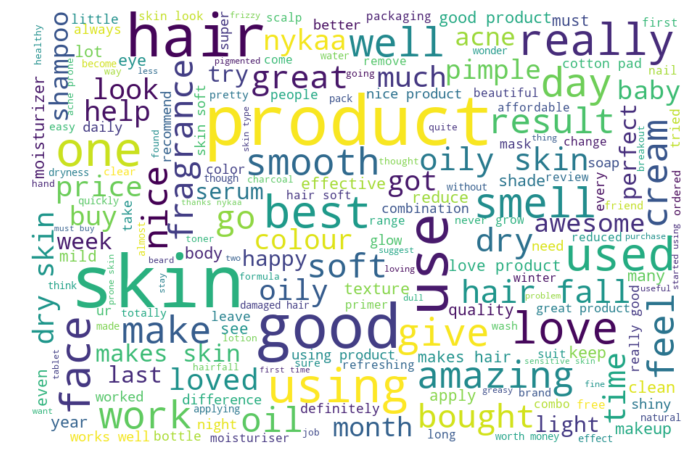

In [15]:
stopset = stopset = set(stopwords.words('english'))
nykaa_website_words = ' '.join([text for text in nykaa_website.review])
nykaa_website_words = ' '.join([w for w in nykaa_website_words.split() if not w in stopset])
wordcloud = WordCloud(background_color = "white",width=900, height=600, random_state=21, max_font_size=100).generate(nykaa_website_words)
print('Overall wordcloud for Nykaa website data')
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [16]:
nykaa_polarity = list(np.round(booster.predict(xgb.DMatrix(bag_of_words_vectorizer.transform(nykaa_website.review))),2))
nykaa_subjectivity = [np.round(TB(nykaa_website.review[i]).sentiment[1],2) for i in range(len(nykaa_website))]
nykaa_sentiment = [sentiment_analyzer(x) for x in nykaa_polarity]

In [17]:
nykaa_website['sentiment'] = pd.DataFrame({'sentiment':nykaa_sentiment})
nykaa_website['polarity'] = pd.DataFrame({'polarity':nykaa_polarity})
nykaa_website['subjectivity'] = pd.DataFrame({'subjectivity':nykaa_subjectivity})

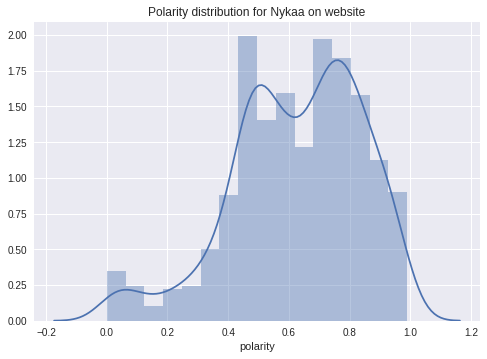

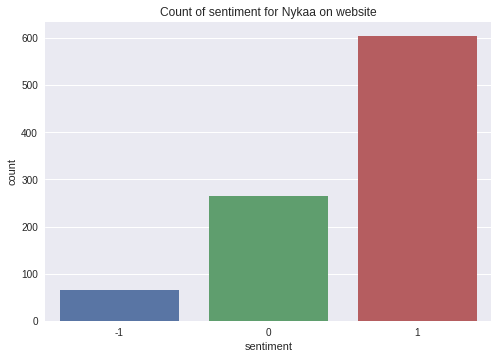

In [18]:
plt.title('Polarity distribution for Nykaa on website')
sns.distplot(nykaa_website.polarity)
plt.show()

plt.title('Count of sentiment for Nykaa on website')
sns.countplot(nykaa_website.sentiment)
plt.show()

Positive wordcloud for Nykaa website data


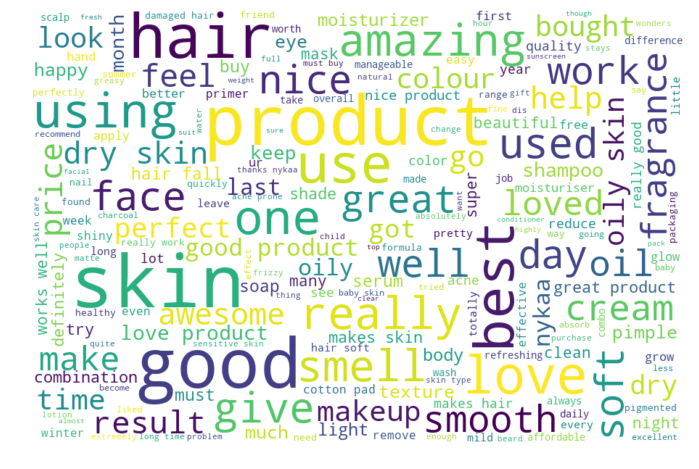

In [19]:
nykaa_website_positive = nykaa_website[nykaa_website.sentiment == 1]
nykaa_website_negative = nykaa_website[nykaa_website.sentiment == -1]
nykaa_website_neutral = nykaa_website[nykaa_website.sentiment == 0]

nykaa_website_words_positive = ' '.join([text for text in nykaa_website_positive.review])
nykaa_website_words_positive = ' '.join([w for w in nykaa_website_words_positive.split() if not w in stopset])
try:
    print('Positive wordcloud for Nykaa website data')
    wordcloud = WordCloud(background_color="white",width=900, height=600, random_state=21, max_font_size=100).generate(nykaa_website_words_positive)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
except ValueError:
    pass


Negative wordcloud for Nykaa website data


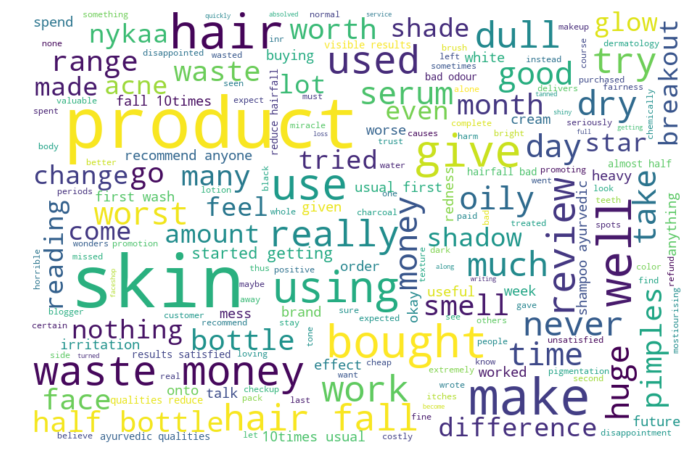

In [20]:
nykaa_website_words_negative = ' '.join([text for text in nykaa_website_negative.review])
nykaa_website_words_negative = ' '.join([w for w in nykaa_website_words_negative.split() if not w in stopset])
try:
    print('Negative wordcloud for Nykaa website data')
    wordcloud = WordCloud(background_color="white",width=900, height=600, random_state=21, max_font_size=100).generate(nykaa_website_words_negative)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
except ValueError:
    pass

Neutral wordcloud for Nykaa website reviews


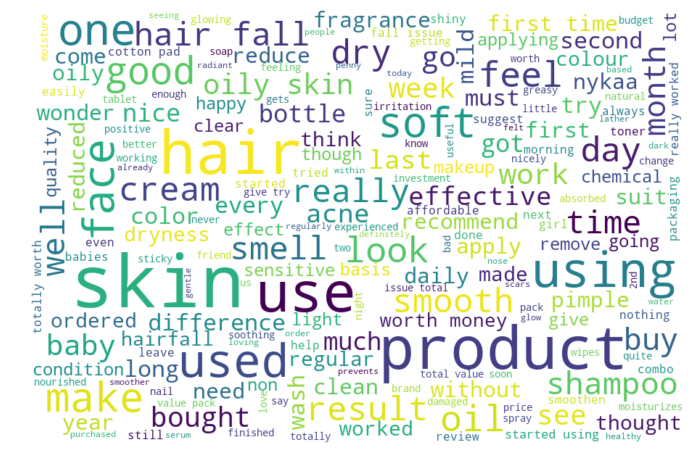

In [21]:
nykaa_website_words_neutral = ' '.join([text for text in nykaa_website_neutral.review])
nykaa_website_words_neutral = ' '.join([w for w in nykaa_website_words_neutral.split() if not w in stopset])
try:
    print('Neutral wordcloud for Nykaa website reviews')
    wordcloud = WordCloud(background_color="white",width=900, height=600, random_state=21, max_font_size=100).generate(nykaa_website_words_neutral)

    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
except ValueError:
    pass

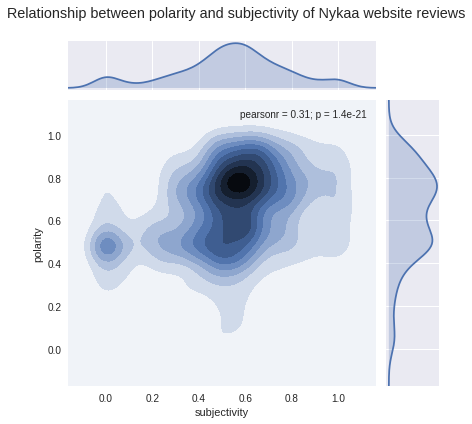

In [22]:
g = sns.jointplot(x="subjectivity", y="polarity", data=nykaa_website,kind='kde')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between polarity and subjectivity of Nykaa website reviews")
plt.show()

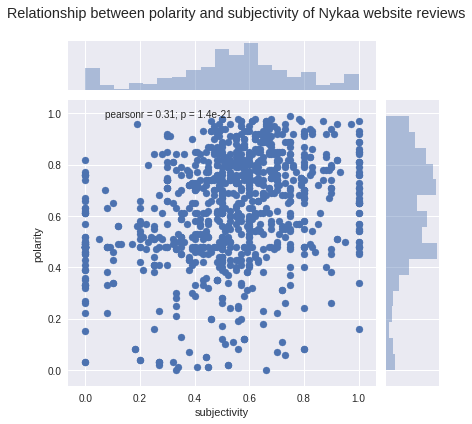

In [23]:
g = sns.jointplot(x="subjectivity", y="polarity", data=nykaa_website)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between polarity and subjectivity of Nykaa website reviews")
plt.show()

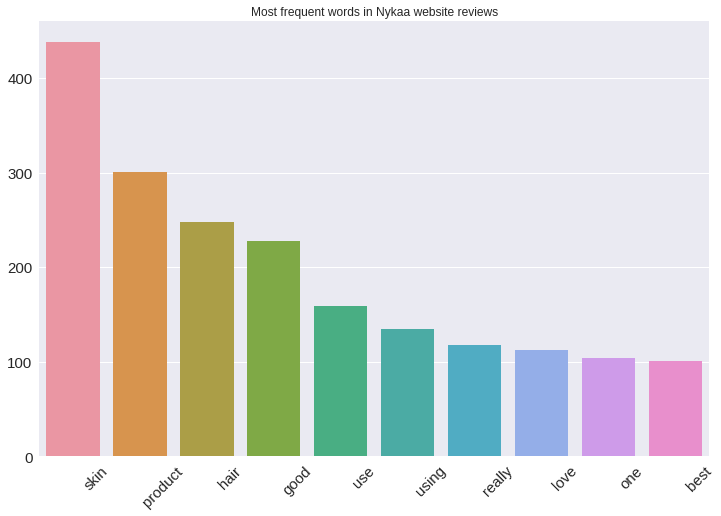

In [24]:
nykaa_website_dictionary = list(nykaa_website.review)
def joinStrings(dictionary):
    return ' '.join(string for string in dictionary)

nykaa_website_dictionary = joinStrings(nykaa_website_dictionary)

nykaa_website_dictionary = [w for w in nykaa_website_dictionary.split() if not w in stopset]
counts = dict(Counter(nykaa_website_dictionary).most_common(10))

labels, values = zip(*counts.items())
indSort = np.argsort(values)[::-1]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.figure(figsize = (12,8))
plt.title('Most frequent words in Nykaa website reviews')
b=sns.barplot(indexes, values)
b.tick_params(labelsize=15)
plt.xticks(indexes + bar_width, labels)
plt.xticks(rotation=45)
plt.show()

In [25]:
nykaa_website1 = nykaa_website[(nykaa_website.time>= datetime(2018, 3, 1)) & (nykaa_website.time< datetime(2018, 4, 1))].reset_index(drop = True)
nykaa_website2 = nykaa_website[(nykaa_website.time>= datetime(2018, 4, 1)) & (nykaa_website.time< datetime(2018, 5, 1))].reset_index(drop = True)
nykaa_website3 = nykaa_website[(nykaa_website.time>= datetime(2018, 5, 1)) & (nykaa_website.time< datetime(2018, 6, 1))].reset_index(drop = True)
nykaa_website4 = nykaa_website[(nykaa_website.time>= datetime(2018, 6, 1)) & (nykaa_website.time< datetime(2018, 7, 1))].reset_index(drop = True)
nykaa_website5 = nykaa_website[(nykaa_website.time>= datetime(2018, 7, 1)) & (nykaa_website.time< datetime(2018, 8, 1))].reset_index(drop = True)
nykaa_website6 = nykaa_website[(nykaa_website.time>= datetime(2018, 8, 1))].reset_index(drop = True)

In [26]:
def time_bin(x):
    if x >= datetime(2018,3,1) and x<datetime(2018,4,1):
        x=1
    elif x >= datetime(2018,4,1) and x<datetime(2018,5,1):
        x=2
    elif x >= datetime(2018,5,1) and x<datetime(2018,6,1):
        x=3
    elif x >= datetime(2018,6,1) and x<datetime(2018,7,1):
        x=4
    elif x >= datetime(2018,7,1) and x<datetime(2018,8,1):
        x=5
    else:
        x=6
    return x

nykaa_website['Time Bin'] = nykaa_website.time.map(lambda x:time_bin(x))               

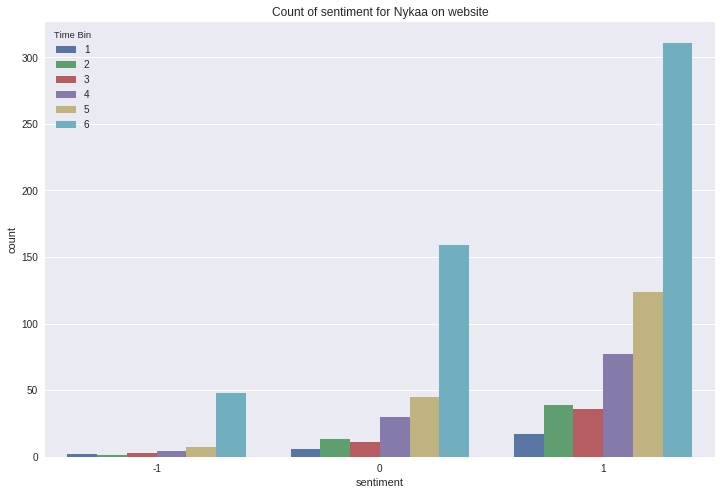

In [27]:
plt.figure(figsize = (12,8))
plt.title('Count of sentiment for Nykaa on website')
sns.countplot(nykaa_website.sentiment, hue = nykaa_website['Time Bin'])
plt.show()

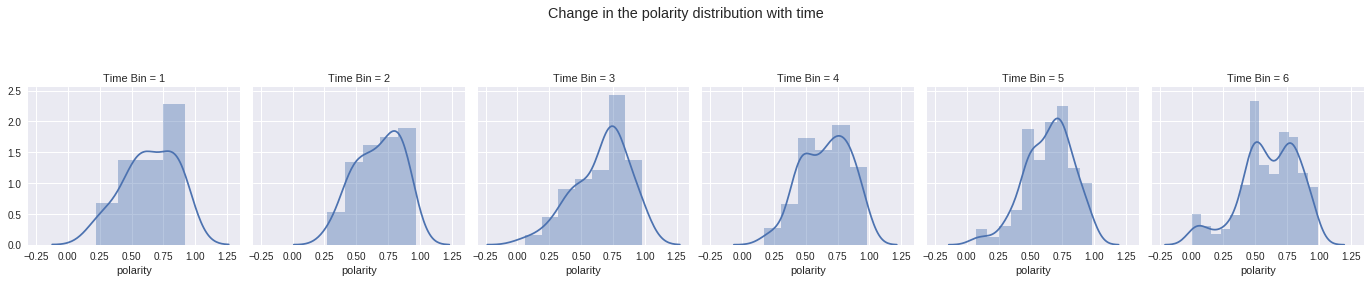

In [28]:
g = sns.FacetGrid(nykaa_website, col="Time Bin", size = 4, aspect =0.8)
g.map(sns.distplot, "polarity")
plt.subplots_adjust(top=0.7)
g.fig.suptitle('Change in the polarity distribution with time')
plt.show()

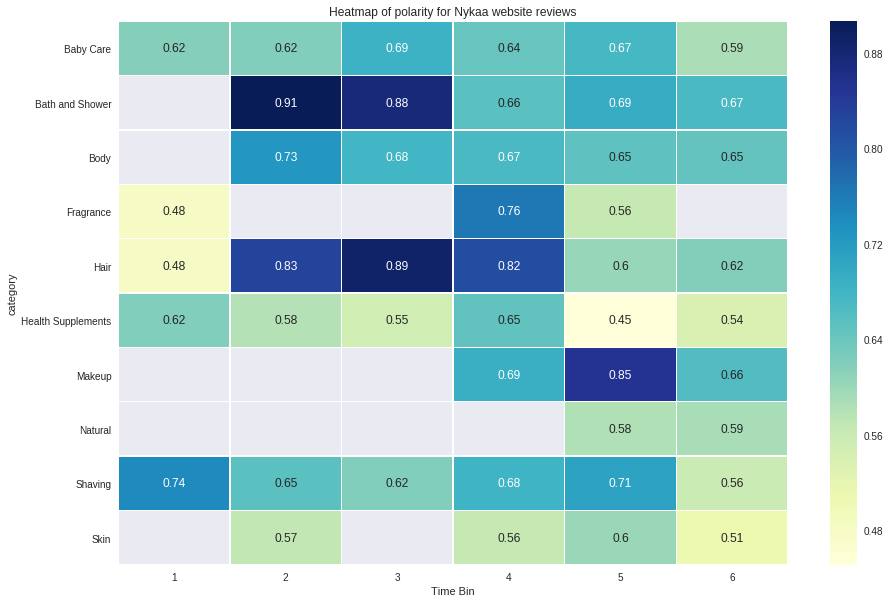

In [29]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(15,10))  
ax.set_title('Heatmap of polarity for Nykaa website reviews')
nykaa_website_heatmap = nykaa_website.pivot_table(index="category",columns="Time Bin", values='polarity')
sns.heatmap(nykaa_website_heatmap,ax=ax,annot=True,linewidths=.5,cmap="YlGnBu")
plt.show()

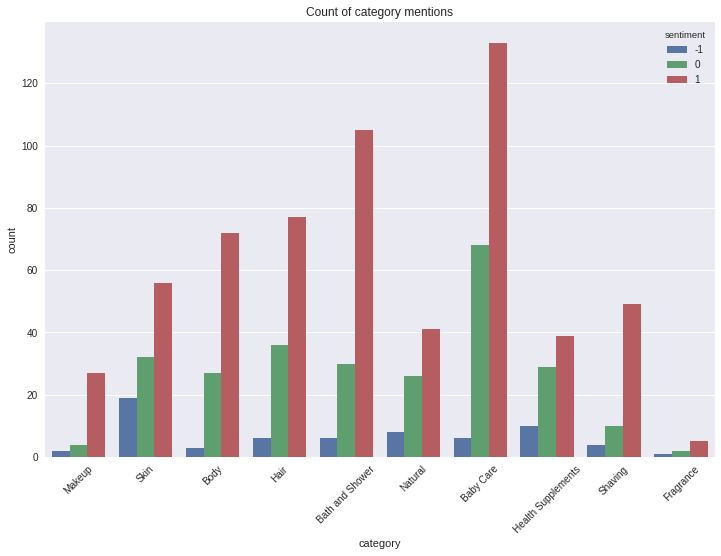

In [30]:
plt.figure(figsize = (12,8))
plt.title('Count of category mentions')
sns.countplot(nykaa_website.category, hue=nykaa_website.sentiment)
plt.xticks(rotation=45)
plt.show()

In [31]:
nykaa_website.to_excel('purplle_website_reviews.xlsx', index = False)